## Sentiment Analysis of Amazon Review Data

In [11]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB

In [12]:
with open('config.json') as json_data_file:
    config = json.load(json_data_file)

In [13]:
data = pd.read_csv("./Data_filtered/reviews_Patio_Lawn_and_Garden.csv", sep=";")
data.head(5)

,review,rating,products
0,"['good', 'usa', 'company', 'stands', 'behind',...",4.0,B00KS0F4FI
1,"['high', 'quality', 'eight', 'ply', 'hose', 'g...",5.0,B00KS0F4FI
2,"['probably', 'one', 'best', 'hoses', 'ever', '...",4.0,B00KS0F4FI
3,"['probably', 'bought', 'something', 'bit', 'fl...",5.0,B00KS0F4FI
4,"['bought', 'three', '58inch', 'flexogen', 'hos...",5.0,B00KS0F4FI


In [14]:
# 1, 2, 3 = negativ 4, 5 = positiv
data["label"] = pd.cut(data["rating"], bins = config["label_two"]["bins"], labels = config["label_two"]["labels"])
data["label"] = data["label"].astype(str)
data.head(5)

,review,rating,products,label
0,"['good', 'usa', 'company', 'stands', 'behind',...",4.0,B00KS0F4FI,positiv
1,"['high', 'quality', 'eight', 'ply', 'hose', 'g...",5.0,B00KS0F4FI,positiv
2,"['probably', 'one', 'best', 'hoses', 'ever', '...",4.0,B00KS0F4FI,positiv
3,"['probably', 'bought', 'something', 'bit', 'fl...",5.0,B00KS0F4FI,positiv
4,"['bought', 'three', '58inch', 'flexogen', 'hos...",5.0,B00KS0F4FI,positiv


In [15]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

#Vectorizer
vect = CountVectorizer()

#feature selection
f_select = SelectKBest(f_classif, k=10000)
f_select = SelectPercentile(f_classif, percentile=20)

#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)
#clf = LinearSVC(C=1.0, penalty= "l1", max_iter=3000, dual=False)


#Building the Pipeline
pipeline = Pipeline([('vect', vect),
                     ('f_select', f_select), 
                     ('clf', clf)])


In [16]:
from sklearn import metrics
model = pipeline.fit(X_train, y_train)

#Results step of Pipeline
vectorizer = model.named_steps['vect']
feature_selection = model.named_steps['f_select']
classifier = model.named_steps['clf']

#Accuracy score of Train Data
print("accuracy score: " + str(model.score(X_train, y_train)))

accuracy score: 0.865121974192333


In [17]:
from sklearn.metrics import accuracy_score
model = pipeline.fit(X_train, y_train)

#Accuracy Score of Model prediction 
print("accuracy score: " + str(model.score(X_test, y_test)))

#Report on prediction of model
predictions = model.predict(X_test)
print("Classificaton Report:")
print(metrics.classification_report(y_true=y_test, y_pred=predictions))

accuracy score: 0.7902071563088512
Classificaton Report:
              precision    recall  f1-score   support

     negativ       0.51      0.49      0.50       570
     positiv       0.86      0.87      0.87      2085

   micro avg       0.79      0.79      0.79      2655
   macro avg       0.69      0.68      0.68      2655
weighted avg       0.79      0.79      0.79      2655



In [18]:
#Test with Manual review Text
print(model.predict(['My thing broke, very bad']))
print(model.predict(['My order broke and I am very disappointed']))
print(model.predict(['My order works perfect and and I am very glad I bought it']))

['negativ']
['negativ']
['positiv']


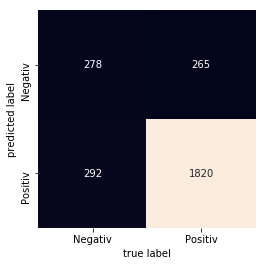

In [20]:
#Confusion matrix of model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = model.predict(X_test)
target_names = ['Negativ', 'Positiv']
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()